# SSN Main

In [1]:
# Torch related imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Data visualisation and numerical computing
import matplotlib.pyplot as plt
import numpy as np
import math

# Network analysis
import networkx as nx
from matplotlib.gridspec import GridSpec

# Additional useful imports
import pandas as pd  
import seaborn as sns  
import os  
import sys  
import logging  

torch.manual_seed(0)
np.random.seed(0)

plt.rcParams['figure.figsize'] = (10, 6)

# Configure logging
logging.basicConfig(level=logging.INFO)


In [2]:

class GridParameters:
    def __init__(self, gridsize_Nx, gridsize_deg, magnif_factor, hyper_col):
        self.gridsize_Nx = gridsize_Nx
        self.gridsize_deg = gridsize_deg
        self.magnif_factor = magnif_factor
        self.hyper_col = hyper_col

In [3]:
def Euler2fixedpt(dxdt, x_initial, Tmax, dt, xtol=1e-5, xmin=1e-0, Tmin=200, PLOT=False, inds=None, verbose=True, device='cpu', dtype=torch.float32):
    """
    Finds the fixed point of the D-dim ODE set dx/dt = dxdt(x), using the
    Euler update with sufficiently large dt (to gain in computational time).
    Checks for convergence to stop the updates early.

    Args:
    dxdt (function): A function handle giving the right-hand side function of the dynamical system.
    x_initial (torch.Tensor): Initial condition for state variables (a column vector).
    Tmax (float): Maximum time to which it would run the Euler (same units as dt, e.g., ms).
    dt (float): Time step of Euler.
    xtol (float, optional): Tolerance in relative change in x for determining convergence.
    xmin (float, optional): For x(i)<xmin, it checks convergence based on absolute change, which must be smaller than xtol*xmin.
    Tmin (float, optional): Minimum time for convergence check.
    PLOT (bool, optional): If True, plot the convergence of some component.
    inds (list or torch.Tensor, optional): Indices of x (state-vector) to plot.
    verbose (bool, optional): If True, print convergence information.
    device (str or torch.device, optional): Device to run the computation on ('cpu' or 'cuda').
    dtype (torch.dtype, optional): Data type of the tensors.

    Returns:
    xvec (torch.Tensor): Found fixed point solution.
    CONVG (bool): True if determined converged, False if not.
    """

    x_initial = x_initial.to(device=device, dtype=dtype)

    if PLOT:
        if inds is None:
            N = x_initial.numel()
            inds = torch.tensor([int(N/4), int(3*N/4)], device=device, dtype=torch.long)
        xplot = x_initial[inds].view(-1, 1)

    Nmax = int(round(Tmax / dt))
    Nmin = int(round(Tmin / dt)) if Tmax > Tmin else int(Nmax / 2)
    xvec = x_initial.clone()
    CONVG = False
    for n in range(Nmax):
        dx = dxdt(xvec) * dt
        xvec = xvec + dx
        if PLOT:
            xplot = torch.cat((xplot, xvec[inds].view(-1, 1)), dim=1)

        if n > Nmin:
            rel_change = torch.abs(dx / torch.maximum(torch.tensor(xmin, device=xvec.device, dtype=xvec.dtype), torch.abs(xvec)))
            if rel_change.max() < xtol:
                if verbose:
                    print("      converged to fixed point at iter={},      as max(abs(dx./max(xvec,{}))) < {} ".format(n, xmin, xtol))
                CONVG = True
                break

    if not CONVG:  # n == Nmax
        print("\n Warning 1: reached Tmax={}, before convergence to fixed point.".format(Tmax))
        print("       max(abs(dx./max(abs(xvec), {}))) = {},   xtol={}.\n".format(xmin, rel_change.max().item(), xtol))

    if PLOT:
        plt.figure(244459)
        plt.plot(torch.arange(n+2).to(dtype=dtype, device=device) * dt, xplot.cpu().numpy(), 'o-')

    return xvec, CONVG

In [8]:

class _SSN_Base(object):
    def __init__(self, n, k, Ne, Ni, tau_vec=None, W=None, device='cpu', dtype=torch.float32):
        self.n = n
        self.k = k
        self.Ne = Ne
        self.Ni = Ni
        self.N = self.Ne + self.Ni
        
        # Use a boolean tensor to represent 'E' (True) and 'I' (False) neuron types
        self.EI = torch.zeros(self.N, dtype=torch.bool, device=device)
        self.EI[:Ne] = True  # Set the first Ne elements to True representing 'E' neurons
        
        # Convert numpy arrays to PyTorch tensors and move them to the specified device
        self.tau_vec = tau_vec.to(device) if tau_vec is not None else None
        self.W = W.to(device) if W is not None else None

        self.device = device
        self.dtype = dtype

    @property
    def neuron_params(self):
        return dict(n=self.n, k=self.k)

    @property
    def dim(self):
        return self.N

    @property
    def tau_x_vec(self):
        """ time constants for the generalised state-vector, x """
        return self.tau_vec

    def powlaw(self, u):
        return self.k * F.relu(u).pow(self.n)

    def drdt(self, r, inp_vec):
            
        return (-r + self.powlaw(self.W @ r + inp_vec)) / self.tau_vec

    def drdt_multi(self, r, inp_vec):
        """
        Compared to self.drdt allows for inp_vec and r to be
        matrices with arbitrary shape[1]
        """
        return ((-r + self.powlaw(torch.mm(self.W, r) + inp_vec)).transpose(0,1) / self.tau_vec).transpose(0,1)

    def dxdt(self, x, inp_vec):
        """
        Allowing for descendant SSN types whose state-vector, x, is different
        than the rate-vector, r.
        """
        return self.drdt(x, inp_vec)

    def gains_from_v(self, v):
        return self.n * self.k * F.relu(v).pow(self.n - 1)

    def gains_from_r(self, r):
        return self.n * self.k**(1/self.n) * r.pow(1 - 1/self.n)

    def DCjacobian(self, r):
        """
        DC Jacobian (i.e. zero-frequency linear response) for
        linearization around rate vector r
        """
        Phi = self.gains_from_r(r)
        return -torch.eye(self.N, device=self.device, dtype=self.dtype) + Phi[:, None] * self.W

    def jacobian(self, DCjacob=None, r=None):
        """
        Dynamic Jacobian for linearisation around rate vector r
        """
        if DCjacob is None:
            assert r is not None, "Either DCjacob or r must be provided."
            DCjacob = self.DCjacobian(r)
        return DCjacob / self.tau_x_vec[:, None]

    def jacobian_eigvals(self, DCjacob=None, r=None):
        Jacob = self.jacobian(DCjacob=DCjacob, r=r)
        return torch.linalg.eigvals(Jacob)

    def inv_G(self, omega, DCjacob, r=None):
        """
        Inverse Green's function at angular frequency omega,
        for linearization around rate vector r
        """
        if DCjacob is None:
            assert r is not None, "Either DCjacob or r must be provided."
            DCjacob = self.DCjacobian(r)
        return -1j * omega * torch.diag(self.tau_x_vec) - DCjacob
    
    def fixed_point_r(self, inp_vec, r_init=None, Tmax=500, dt=1, xtol=1e-5, PLOT=False, verbose=True, device='cpu', dtype=torch.float32):
        """
        Find the fixed point for rate dynamics, given an input vector.
        
        Args:
        inp_vec (torch.Tensor): Input vector.
        r_init (torch.Tensor, optional): Initial guess for rate vector.
        Tmax (float, optional): Maximum time to run the Euler method.
        dt (float, optional): Time step for Euler method.
        xtol (float, optional): Tolerance for convergence.
        PLOT (bool, optional): If True, plot the convergence.
        verbose (bool, optional): If True, print convergence information.
        device (str or torch.device, optional): Device to run the computation on ('cpu' or 'cuda').
        dtype (torch.dtype, optional): Data type of the tensors.

        Returns:
        r_fp (torch.Tensor): Fixed point rate vector.
        CONVG (bool): True if convergence was achieved, False otherwise.
        """
        inp_vec = inp_vec.to(device=device, dtype=dtype)
        
        if r_init is None:
            r_init = torch.zeros_like(inp_vec)
        else:
            r_init = r_init.to(device=device, dtype=dtype)
        
        drdt = lambda r : self.drdt(r, inp_vec)
        if inp_vec.ndim > 1:
            drdt = lambda r : self.drdt_multi(r, inp_vec)
        
        test_r = torch.ones_like(inp_vec)  # Replace with an appropriate test value
        print("PyTorch: drdt(test_r) =", drdt(test_r).shape)
            
        r_fp, CONVG = Euler2fixedpt(drdt, r_init, Tmax, dt, xtol=xtol, PLOT=PLOT, verbose=verbose, device=device, dtype=dtype)
        if not CONVG:
            print('Did not reach fixed point.')
            
        return r_fp, CONVG

    def fixed_point(self, inp_vec, x_init=None, Tmax=500, dt=1, xtol=1e-5, PLOT=False, device='cpu', dtype=torch.float32):
        """
        Find the fixed point for the system dynamics, given an input vector.

        Args are similar to `fixed_point_r`.

        x_fp (torch.Tensor): Fixed point state vector.
        CONVG (bool): True if convergence was achieved, False otherwise.
        """
        inp_vec = inp_vec.to(device=device, dtype=dtype)
        
        if x_init is None:
            x_init = torch.zeros((self.dim,), device=device, dtype=dtype)
        else:
            x_init = x_init.to(device=device, dtype=dtype)
            
        dxdt = lambda x : self.dxdt(x, inp_vec)
        x_fp, CONVG = Euler2fixedpt(dxdt, x_init, Tmax, dt, xtol=xtol, PLOT=PLOT, device=device, dtype=dtype)
        if not CONVG:
            print('Did not reach fixed point.')
            
        return x_fp, CONVG

    def make_noise_cov(self, noise_pars, device='cpu', dtype=torch.float32):
        """
        Create the noise covariance matrix based on noise parameters.

        Args:
        noise_pars (object): An object that has attributes 'stdevE' and 'stdevI', representing standard deviations.
        device (str or torch.device, optional): Device to run the computation on ('cpu' or 'cuda').
        dtype (torch.dtype, optional): Data type of the tensors.

        Returns:
        noise_sigsq (torch.Tensor): Noise variances.
        spatl_filt (torch.Tensor): Spatial filter.
        """
        noise_sigsq = torch.cat([
            (noise_pars.stdevE ** 2) * torch.ones(self.Ne, device=device, dtype=dtype),
            (noise_pars.stdevI ** 2) * torch.ones(self.Ni, device=device, dtype=dtype)
        ])
        spatl_filt = torch.tensor(1, device=device, dtype=dtype)

        return noise_sigsq, spatl_filt

In [11]:


class SSN2DTopoV1(_SSN_Base,nn.Module):
    _Lring = 180

    def __init__(self, n, k, tauE, tauI, grid_pars, conn_pars, **kwargs):
        Ne = Ni = grid_pars.gridsize_Nx ** 2
        tau_vec = torch.cat([tauE * torch.ones(Ne), tauI * torch.ones(Ni)])
        super(SSN2DTopoV1, self).__init__(n=n, k=k, Ne=Ne, Ni=Ni, tau_vec=tau_vec, **kwargs)
        self.grid_pars = grid_pars
        self.conn_pars = conn_pars
        self._make_maps(grid_pars)
        if conn_pars is not None:
            self.make_W(**conn_pars)

    @property
    def neuron_params(self):
        # Return a dictionary of neuron parameters
        return dict(n=self.n, k=self.k, tauE=self.tau_vec[0], tauI=self.tau_vec[self.Ne])

    @property
    def maps_vec(self):
        # Combine x, y, and orientation vectors and return them as a matrix
        return torch.stack([self.x_vec, self.y_vec, self.ori_vec]).T

    @property
    def center_inds(self):
        """ Indices of center-E and center-I neurons """
        # Find the indices where x and y coordinates are both zero
        return torch.where((self.x_vec == 0) & (self.y_vec == 0))[0]

    @property
    def x_vec_degs(self):
        # Convert x coordinates from mm to degrees
        return self.x_vec / self.grid_pars.magnif_factor

    @property
    def y_vec_degs(self):
        # Convert y coordinates from mm to degrees
        return self.y_vec / self.grid_pars.magnif_factor

    def xys2inds(self, xys=[[0, 0]], units="degree"):
        """
        Indices of E and I neurons at location (x,y) (by default in degrees).
        Args:
            xys: List or array-like object containing xy coordinates.
            units: Specifies unit for xys. By default, "degree" of visual angle.
        Returns:
            inds: Tensor of shape (2, len(xys)), where inds[0] contains indices of E neurons
                  and inds[1] contains indices of I neurons.
        """
        inds = []
        for xy in xys:
            if units == "degree":  # Convert to mm
                xy = self.grid_pars.magnif_factor * torch.tensor(xy)
            distsq = (self.x_vec - xy[0])**2 + (self.y_vec - xy[1])**2
            inds.append([torch.argmin(distsq[:self.Ne]), self.Ne + torch.argmin(distsq[self.Ne:])])
        return torch.tensor(inds).T

    def xys2Emapinds(self, xys=[[0, 0]], units="degree"):
        """
        (i,j) of E neurons at location (x,y) (by default in degrees).
        Args:
            xys: List or array-like object containing xy coordinates.
            units: Specifies unit for xys. By default, "degree" of visual angle.
        Returns:
            map_inds: Tensor of shape (2, len(xys)), where inds[0] contains row indices of E neurons in map
                      and inds[1] contains column indices of E neurons in map.
        """
        def vecind2mapind(i):
            return torch.tensor([i % self.grid_pars.gridsize_Nx, i // self.grid_pars.gridsize_Nx])
        
        return vecind2mapind(self.xys2inds(xys)[0])

    def vec2map(self, vec):
        """
        Reshape a 1-dimensional tensor to a 2-dimensional map or a pair of maps.
        Args:
            vec: 1-dimensional tensor.
        Returns:
            map: If vec corresponds to E neurons, a single 2D map is returned.
                 If vec corresponds to all neurons, a tuple of E and I maps is returned.
        """
        assert vec.ndim == 1
        Nx = self.grid_pars.gridsize_Nx
        if len(vec) == self.Ne:
            map = vec.view(Nx, Nx)
        elif len(vec) == self.N:
            map = (vec[:self.Ne].reshape((Nx, Nx)), vec[self.Ne:].reshape((Nx, Nx)))
        return map

    def _make_maps(self, grid_pars=None):
        """
        Create retinotopic and orientation maps.
        """
        if grid_pars is None:
            grid_pars = self.grid_pars
        else:
            self.grid_pars = grid_pars

        self._make_retinmap()
        self._make_orimap()

        return self.x_map, self.y_map, self.ori_map

    def _make_retinmap(self, grid_pars=None):
        """
        Create square grid of locations with X and Y retinotopic maps.
        """
        if grid_pars is None:
            grid_pars = self.grid_pars
        else:
            self.grid_pars = grid_pars

        if not hasattr(grid_pars, "gridsize_mm"):
            self.grid_pars.gridsize_mm = grid_pars.gridsize_deg * grid_pars.magnif_factor

        Lx = Ly = self.grid_pars.gridsize_mm
        Nx = Ny = grid_pars.gridsize_Nx
        dx = dy = Lx / (Nx - 1)

        self.grid_pars.dx = dx  # in mm
        self.grid_pars.dy = dy  # in mm

        xs = torch.linspace(0, Lx, Nx)
        ys = torch.linspace(0, Ly, Ny)
        X, Y = torch.meshgrid(xs - xs[len(xs) // 2], ys - ys[len(ys) // 2])
        Y = -Y  # without this Y decreases going upwards

        self.x_map = X
        self.y_map = Y
        self.x_vec = X.ravel().repeat(2)
        self.y_vec = Y.ravel().repeat(2)
        return self.x_map, self.y_map

    def _make_orimap(self, hyper_col=None, nn=30, X=None, Y=None):
        """
        Makes the orientation map for the grid, by superposition of plane-waves.
        """
        if hyper_col is None:
            hyper_col = self.grid_pars.hyper_col
        else:
            self.grid_pars.hyper_col = hyper_col

        X = self.x_map if X is None else X
        Y = self.y_map if Y is None else Y

        z = torch.zeros_like(X, dtype=torch.complex128)
        for j in range(nn):
            kj = torch.tensor([np.cos(j * np.pi / nn), np.sin(j * np.pi / nn)]) * 2 * np.pi / (hyper_col)
            sj = 2 * np.random.choice([-1, 1])  # random number that's either + or -1
            phij = np.random.rand() * 2 * np.pi

            tmp = (X * kj[0] + Y * kj[1]) * sj + phij
            z = z + torch.exp(1j * tmp)

        # ori map with preferred orientations in the range (0, _Lring] (i.e. (0, 180] by default)
        self.ori_map = (torch.angle(z) + np.pi) * SSN2DTopoV1._Lring / (2 * np.pi)
        self.ori_vec = self.ori_map.ravel().repeat(2)
        return self.ori_map

    def _make_distances(self, PERIODIC):
        """
        Compute distances between neurons in both space and orientation.
        """
        Lx = Ly = self.grid_pars.gridsize_mm

        def absdiff_ring(d_x, L):
            return torch.minimum(torch.abs(d_x), L - torch.abs(d_x))

        if PERIODIC:
            absdiff_x = absdiff_y = lambda d_x: absdiff_ring(d_x, Lx + self.grid_pars.dx)
        else:
            absdiff_x = absdiff_y = lambda d_x: torch.abs(d_x)

        xs = self.x_vec.reshape(2, self.Ne, 1)  # (cell-type, grid-location, None)
        ys = self.y_vec.reshape(2, self.Ne, 1)  # (cell-type, grid-location, None)
        oris = self.ori_vec.reshape(2, self.Ne, 1)  # (cell-type, grid-location, None)

        xy_dist = torch.sqrt(absdiff_x(xs[0] - xs[0].T)**2 + absdiff_y(ys[0] - ys[0].T)**2)
        ori_dist = absdiff_ring(oris[0] - oris[0].T, SSN2DTopoV1._Lring)

        self.xy_dist = xy_dist
        self.ori_dist = ori_dist

        return xy_dist, ori_dist

    def make_W(self, J_2x2, s_2x2, p_local, sigma_oris=45, Jnoise=0,
               Jnoise_GAUSSIAN=False, MinSyn=1e-4, CellWiseNormalized=True,
               PERIODIC=True):  # , prngKey=0):
        """
        make the full recurrent connectivity matrix W
        :param J_2x2: total strength of weights of different pre/post cell-type
        :param s_2x2: ranges of weights between different pre/post cell-type
        :param p_local: relative strength of local parts of E projections
        :param sigma_oris: range of weights in terms of preferred orientation difference
        :param Jnoise: amount of noise to add
        :param Jnoise_GAUSSIAN: if True, noise is Gaussian, otherwise it's uniform
        :param MinSyn: minimum synaptic weight
        :param CellWiseNormalized: if True, normalize weights cell-wise
        :param PERIODIC: if True, use periodic boundary conditions
        :return: connectivity matrix W
        """
        conn_pars = locals()
        conn_pars.pop("self")
        self.conn_pars = conn_pars


        if hasattr(self, "xy_dist") and hasattr(self, "ori_dist"):
            xy_dist = self.xy_dist
            ori_dist = self.ori_dist
        else:
            xy_dist, ori_dist = self._make_distances(PERIODIC)

        # Check if sigma_oris is a scalar
        sigma_oris = torch.tensor(sigma_oris)
        if sigma_oris.numel() == 1:
            sigma_oris = sigma_oris * torch.ones((2, 2))

        #if not torch.is_tensor(sigma_oris):
        # If it's not a tensor, we make it into a 2x2 tensor
            #sigma_oris = torch.full((2, 2), fill_value=sigma_oris, device = self.device)

        p_local = torch.tensor(p_local)
        if p_local.numel() == 1:
            p_local = p_local * torch.ones(2)

        #if not torch.is_tensor(p_local) or p_local.numel() == 1:
           # p_local = torch.full((2,), fill_value=p_local, device=self.device)

        shape = self.xy_dist.shape
        Wblks = [[torch.zeros(shape, device=self.device), torch.zeros(shape, device=self.device)],
                 [torch.zeros(shape, device=self.device), torch.zeros(shape, device=self.device)]]

        # loop over post- (a) and pre-synaptic (b) cell-types
        for a in range(2):
            for b in range(2):
                if b == 0:  # E projections
                    W = torch.exp(-xy_dist / s_2x2[a, b] - ori_dist ** 2 / (2 * sigma_oris[a, b] ** 2))
                elif b == 1:  # I projections
                    W = torch.exp(-xy_dist ** 2 / (2 * s_2x2[a, b] ** 2) - ori_dist ** 2 / (2 * sigma_oris[a, b] ** 2))

                if Jnoise > 0:  # add some noise
                    if Jnoise_GAUSSIAN:
                        jitter = torch.randn_like(W)
                    else:
                        jitter = 2 * torch.rand_like(W) - 1
                    W = (1 + Jnoise * jitter) * W

                # sparsify (set small weights to zero)
                W = torch.where(W < MinSyn, torch.zeros_like(W), W)

                # row-wise normalize
                tW = torch.sum(W, dim=1, keepdim=True)
                if not CellWiseNormalized:
                    tW = tW.mean()
                W = W / tW

                #tW = torch.sum(W, dim=1)
                #if not CellWiseNormalized:
                   # tW = torch.mean(tW)
                #W = W / tW.unsqueeze(1)

                # for E projections, add the local part
                if b == 0:
                    W = p_local[a] * torch.eye(*W.shape, device=self.device) + (1 - p_local[a]) * W

                Wblks[a][b] = J_2x2[a, b] * W

        self.W = torch.cat([
                torch.cat([Wblks[0][0], Wblks[0][1]], dim=1), 
                torch.cat([Wblks[1][0], Wblks[1][1]], dim=1)
            ], dim=0)
        self.W = self.W.float()  # Convert W to float32

        return self.W

    def _make_inp_ori_dep(self, ONLY_E=False, ori_s=None, sig_ori_EF=32, sig_ori_IF=None, gE=1, gI=1):
        """
        Makes the orientation dependence factor for grating or Gabor stimuli (a la Ray & Maunsell 2010)
        :param ONLY_E: if True, only make the E-part of the input vector
        :param ori_s: stimulus orientation
        :param sig_ori_EF: orientation tuning-width of E cells
        :param sig_ori_IF: orientation tuning-width of I cells
        :param gE: amplitude of E part
        :param gI: amplitude of I part
        :return: orientation factor
        """
        if ori_s is None:
            # set stim ori to pref ori of grid center E cell (same as I cell)
            center_E_indices = (self.x_vec == 0) & (self.y_vec == 0) & self.EI
            ori_s = self.ori_vec[center_E_indices]
        if sig_ori_IF is None:
            sig_ori_IF = sig_ori_EF

        distsq = lambda x: torch.min(torch.abs(x), self._Lring - torch.abs(x)) ** 2
        dori = self.ori_vec - ori_s
        if not ONLY_E:
            ori_fac = torch.cat((
                gE * torch.exp(-distsq(dori[:self.Ne]) / (2 * sig_ori_EF ** 2)),
                gI * torch.exp(-distsq(dori[self.Ne:]) / (2 * sig_ori_IF ** 2))
            ))
        else:
            ori_fac = gE * torch.exp(-distsq(dori[:self.Ne]) / (2 * sig_ori_EF ** 2))

        return ori_fac

    def make_grating_input(self, radius_s, sigma_RF=0.4, ONLY_E=False,
                           ori_s=None, sig_ori_EF=32, sig_ori_IF=None, gE=1, gI=1, contrast=1):
        """
        Make grating external input
        :param radius_s: radius of the stimulus
        :param sigma_RF: edge-fall-off scale
        :param ONLY_E: if True, only make the E-part of the input vector
        :param ori_s: stimulus orientation
        :param sig_ori_EF: orientation tuning-width of E cells
        :param sig_ori_IF: orientation tuning-width of I cells
        :param gE: amplitude of E part
        :param gI: amplitude of I part
        :param contrast: contrast of the stimulus
        :return: input vector
        """
        # Make the orientation dependence factor
        ori_fac = self._make_inp_ori_dep(ONLY_E, ori_s, sig_ori_EF, sig_ori_IF, gE, gI)

        # Make the spatial envelope
        sigmoid = lambda x: 1 / (1 + torch.exp(-x))
        M = self.Ne if ONLY_E else self.N
        r_vec = torch.sqrt(self.x_vec_degs[:M] ** 2 + self.y_vec_degs[:M] ** 2)
        spat_fac = sigmoid((radius_s - r_vec) / sigma_RF)

        return contrast * ori_fac * spat_fac

    def make_gabor_input(self, sigma_Gabor=0.5, ONLY_E=False,
                         ori_s=None, sig_ori_EF=32, sig_ori_IF=None, gE=1, gI=1, contrast=1):
        """
        Make the Gabor stimulus (a la Ray & Maunsell 2010) centered on the
        grid-center, with sigma "sigma_Gabor",
        with orientation "ori_s",
        with the orientation tuning-width of E and I parts given by "sig_ori_EF"
        and "sig_ori_IF", respectively, and with amplitude (maximum) of the E and I parts,
        given by "contrast * gE" and "contrast * gI", respectively.
        """
        # Make the orientation dependence factor
        ori_fac = self._make_inp_ori_dep(ONLY_E, ori_s, sig_ori_EF, sig_ori_IF, gE, gI)

        # Make the spatial envelope
        gaussian = lambda x: torch.exp(- x**2 / 2)
        M = self.Ne if ONLY_E else self.N
        r_vec = torch.sqrt(self.x_vec_degs[:M]**2 + self.y_vec_degs[:M]**2)
        spat_fac = gaussian(r_vec / sigma_Gabor)

        return contrast * ori_fac * spat_fac

    def make_eLFP_from_inds(self, LFPinds):
        """
        Makes a single LFP electrode signature (normalized spatial weight
        profile), given the (vectorized) indices of recorded neurons (LFPinds).

        OUT: e_LFP with shape (self.N,)
        """
        if LFPinds is None:
            LFPinds = [0]
        e_LFP = 1 / len(LFPinds) * torch.isin(torch.arange(self.N, device=self.device), torch.tensor(LFPinds, device=self.device)).float()
        return e_LFP.float()

    def make_eLFP_from_xy(self, probe_xys, LFPradius=0.2, unit_xys="degree", unit_rad="mm"):
        """
        Makes 1 or multiple LFP electrodes signatures (normalized spatial weight
        profile over E cells), given the (x,y) retinotopic coordinates of LFP probes.

        IN: probe_xys: shape (#probes, 2). Each row is the (x,y) coordinates of
            a probe/electrode (by default given in degrees of visual angle)
            LFPradius: positive scalar. radius/range of LFP (by default given in mm)
            unit_xys: either "degree" or "mm", unit of LFP_xys
            unit_rad: either "degree" or "mm", unit of LFPradius
        OUT: e_LFP: shape (self.N, #probes) = (self.N, LFP.xys.shape[0])
            Each column is the normalized spatial profile of one probe.
        """
        if unit_rad == "degree":
            LFPradius = self.grid_pars.magnif_factor * LFPradius

        e_LFP = []
        for xy in probe_xys:
            if unit_xys == "degree":  # Convert to mm
                xy = self.grid_pars.magnif_factor * torch.tensor(xy, device=self.device)

            dist_sq = (self.x_vec - xy[0])**2 + (self.y_vec - xy[1])**2
            e_LFP.append(1.0 * (self.EI & (dist_sq < LFPradius**2)))

        return torch.stack(e_LFP).T

    def run_and_visualise_dynamics(self, inp_vec, total_time, dt):
        
        """
        Run the dynamics from a fixed point and visualise the neuron states over time.

        Args:
        inp_vec (torch.Tensor): Input vector to find the fixed point.
        total_time (float): Total time to run the simulation.
        dt (float): Time step for the simulation.
        """
        # Find the fixed point for the given input
        #r_fixed, _ = self.fixed_point(inp_vec)

        # Run the dynamics starting from the fixed point
        num_steps = int(total_time / dt)
        neuron_states = torch.zeros((num_steps, self.N), device=self.device)
        #r = r_fixed
        r = torch.zeros((self.N*2, 1), device=self.device)

        for step in range(num_steps):
            # Calculate rate of change of neuron states
            drdt = self.drdt(r, inp_vec)

            # Euler integration
            r += dt * drdt

            neuron_states[step, :] = r

        # Visualization
        plt.figure(figsize=(12, 6))
        plt.imshow(neuron_states.cpu().numpy().T, aspect='auto', cmap='viridis')
        plt.colorbar(label='Neuron State')
        plt.xlabel('Time Step')
        plt.ylabel('Neuron Index')
        plt.title('Neuron States Over Time')
        plt.show()

In [12]:
grid_pars = GridParameters(
    gridsize_Nx=10,  # Number of grid points in one dimension
    gridsize_deg=90,  # Size of the grid in degrees of visual angle
    magnif_factor=1,  # Magnification factor to convert degrees to mm
    hyper_col=1,  # Hypercolumn 
)

# Define connection parameters
conn_pars = {
    'J_2x2': torch.tensor([[1.82650658, 0.68194475], [2.06815311, 0.5106321]]), 
    's_2x2': torch.tensor([[0.2, 0.4], [0.09, 0.09]]),  
    'p_local': [0.14,0.7],  
    'sigma_oris': 1000,  
}


# Define other parameters
n = 2  
k = 0.04  
tauE = 20 # Time constant for excitatory neurons
tauI = 10  # Time constant for inhibitory neurons

In [13]:
ssn_2d_topo = SSN2DTopoV1(n=n, k=k, tauE=tauE, tauI=tauI, grid_pars=grid_pars, conn_pars=conn_pars)

/Users/khushu/opt/anaconda3/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1695391836761/work/aten/src/ATen/native/TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [14]:
ssn_2d_topo._make_maps()
ssn_2d_topo.make_W(**conn_pars)

tensor([[1.8265, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 1.8265, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.8265,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.5106, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.5106, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.5106]])

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
PyTorch: drdt(test_r) = torch.Size([200])
      converged to fixed point at iter=201,      as max(abs(dx./max(xvec,1.0))) < 1e-06 


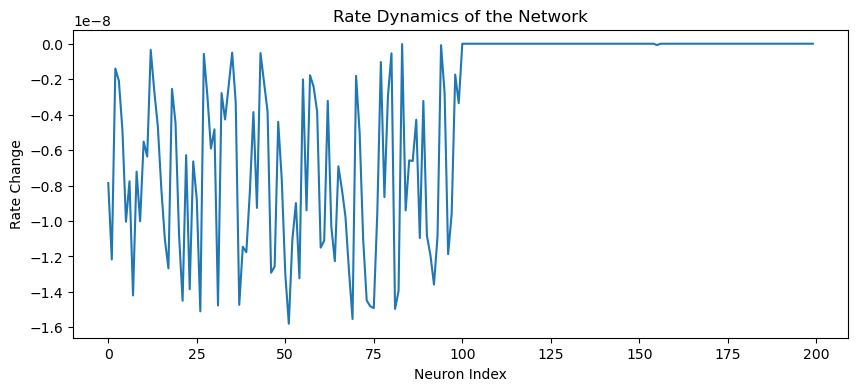

In [15]:
torch.set_default_dtype(torch.float32)

# Creating a simple stimulus for the simulation
radius_s = 0.5
sigma_RF = 0.4
ori_s = 45
sig_ori_EF = 32

gE, gI = 0.37328625, 0.26144141
contrast = 0.6

# Grating stimulus
inp_vec_grating = ssn_2d_topo.make_grating_input(radius_s, sigma_RF, ori_s=ori_s, sig_ori_EF=sig_ori_EF, gE=gE, gI=gI, contrast=contrast)

# Find the network's fixed point response to the grating stimulus
r_init = torch.rand(ssn_2d_topo.N, device=ssn_2d_topo.device,dtype=torch.float32) * 0.01
Tmax = 500
dt = 1
xtol = 1e-6
r_fp_grating, CONVG_grating = ssn_2d_topo.fixed_point_r(inp_vec_grating, r_init, Tmax, dt, xtol)

# Rate dynamics
r_dyn = ssn_2d_topo.drdt(r_fp_grating, inp_vec_grating)

# Plotting 
plt.figure(figsize=(10, 4))
plt.plot(r_dyn.cpu().detach().numpy(), label="Rate Dynamics")
plt.xlabel("Neuron Index")
plt.ylabel("Rate Change")
plt.title("Rate Dynamics of the Network")
plt.show()

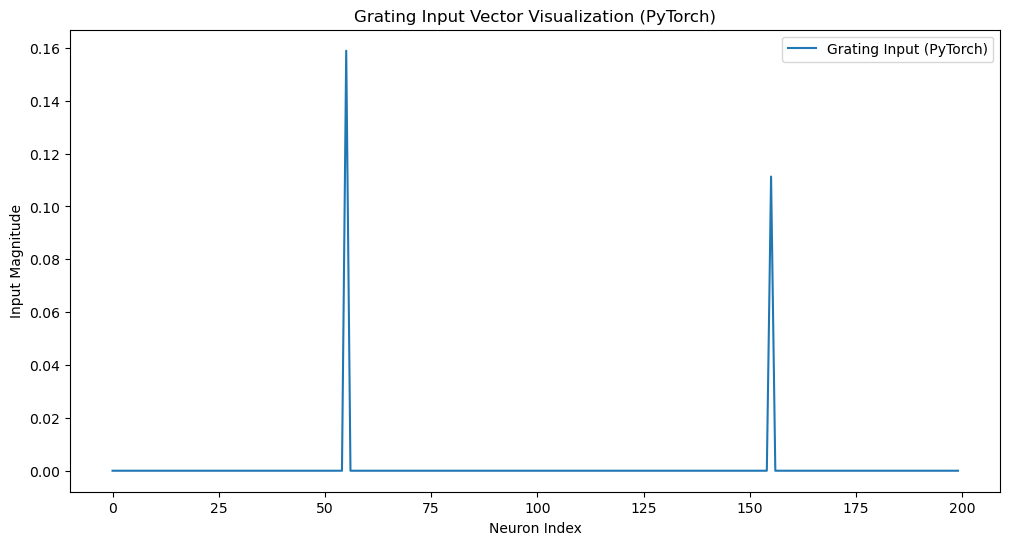

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(inp_vec_grating.cpu().numpy(), label='Grating Input (PyTorch)')
plt.xlabel('Neuron Index')
plt.ylabel('Input Magnitude')
plt.title('Grating Input Vector Visualization (PyTorch)')
plt.legend()
plt.show()

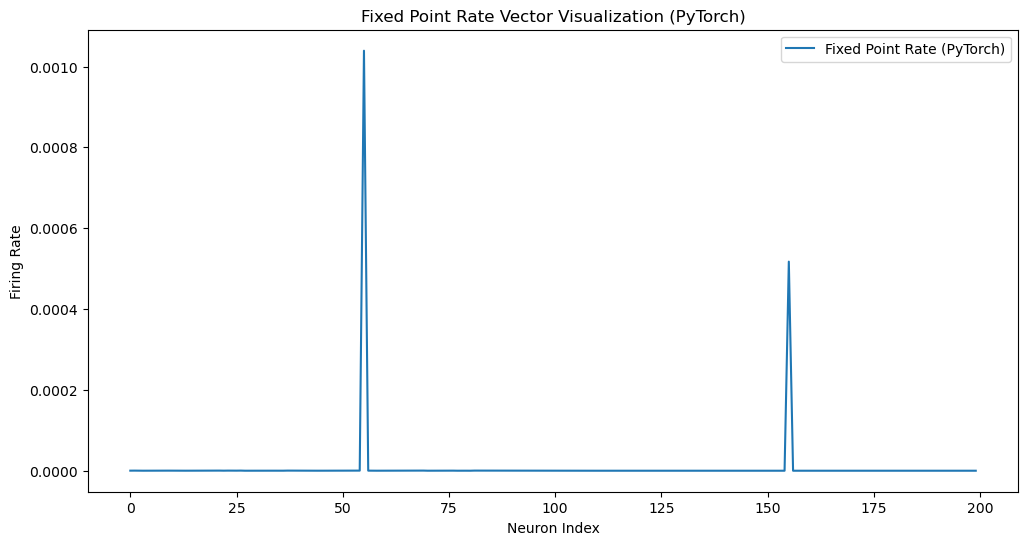

In [17]:
# Visualise the fixed point rate vector
plt.figure(figsize=(12, 6))
plt.plot(r_fp_grating.cpu().detach().numpy(), label='Fixed Point Rate (PyTorch)')
plt.xlabel('Neuron Index')
plt.ylabel('Firing Rate')
plt.title('Fixed Point Rate Vector Visualization (PyTorch)')
plt.legend()
plt.show()

100
PyTorch: drdt(test_r) = torch.Size([200])
      converged to fixed point at iter=201,      as max(abs(dx./max(xvec,1.0))) < 1e-06 
PyTorch: drdt(test_r) = torch.Size([200])
      converged to fixed point at iter=201,      as max(abs(dx./max(xvec,1.0))) < 1e-06 
PyTorch: drdt(test_r) = torch.Size([200])
      converged to fixed point at iter=201,      as max(abs(dx./max(xvec,1.0))) < 1e-06 
PyTorch: drdt(test_r) = torch.Size([200])
      converged to fixed point at iter=201,      as max(abs(dx./max(xvec,1.0))) < 1e-06 
PyTorch: drdt(test_r) = torch.Size([200])
      converged to fixed point at iter=201,      as max(abs(dx./max(xvec,1.0))) < 1e-06 
PyTorch: drdt(test_r) = torch.Size([200])
      converged to fixed point at iter=201,      as max(abs(dx./max(xvec,1.0))) < 1e-06 
PyTorch: drdt(test_r) = torch.Size([200])
      converged to fixed point at iter=201,      as max(abs(dx./max(xvec,1.0))) < 1e-06 
PyTorch: drdt(test_r) = torch.Size([200])
      converged to fixed point at ite

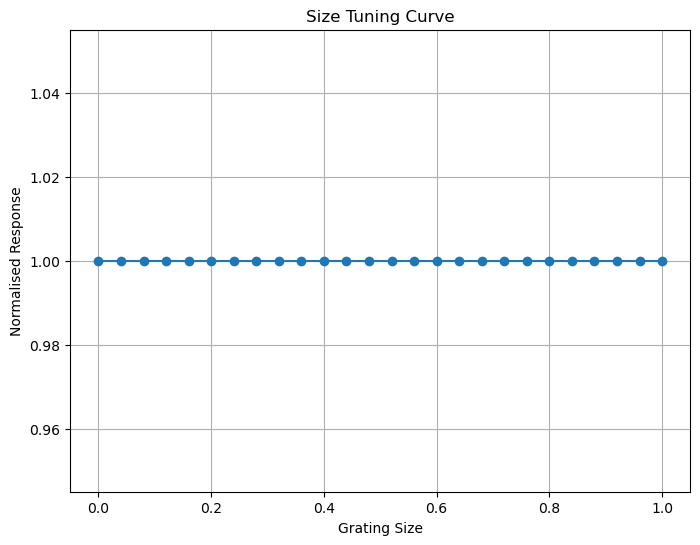

In [18]:
sigma_RF = 1
ori_s = 45
sig_ori_EF = 32
gE = 1
gI = 1
contrast = 0.9

# Define the grid size and identify the central neuron
grid_size = 10
central_neuron_idx = (grid_size // 2) * grid_size + (grid_size // 2)  # Calculate the index of the central neuron
central_neuron_idx = 100
print(central_neuron_idx)

# Define different sizes for the grating stimuli
sizes = torch.arange(0, 1.01, 0.04) 
responses = []
sigma_RF = 0.2

for size in sizes:
    # Generate grating stimulus for each size
    inp_vec_grating = ssn_2d_topo.make_grating_input(size.item(), sigma_RF, ori_s=ori_s, sig_ori_EF=sig_ori_EF, gE=gE, gI=gI, contrast=contrast)

    # Compute the fixed point response
    r_fp_grating, _ = ssn_2d_topo.fixed_point_r(inp_vec_grating, r_init, Tmax, dt, xtol)

    # Extract the response of the central neuron
    central_neuron_response = r_fp_grating[central_neuron_idx]
    responses.append(central_neuron_response)

responses = torch.tensor(responses)  # Convert list to tensor
responses /= torch.mean(responses)

# Plot the size tuning curve
plt.figure(figsize=(8, 6))
plt.plot(sizes.numpy(), responses.numpy(), marker='o')  # Convert tensors to NumPy arrays for plotting
plt.xlabel('Grating Size')
plt.ylabel('Normalised Response')
plt.title('Size Tuning Curve')
plt.grid(True)
plt.show()


In [19]:
W_pytorch = ssn_2d_topo.make_W(**conn_pars)
W_pytorch_np = W_pytorch.detach().cpu().numpy()  # Convert PyTorch tensor to NumPy array

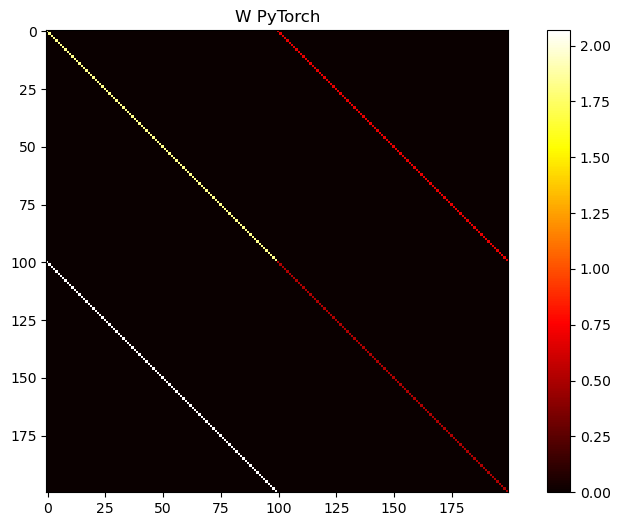

In [20]:
plt.imshow(W_pytorch_np, cmap='hot', interpolation='nearest')
plt.title('W PyTorch')
plt.colorbar()

plt.show()

In [21]:
ori_map_pytorch, x_map_pytorch, y_map_pytorch = ssn_2d_topo._make_maps()

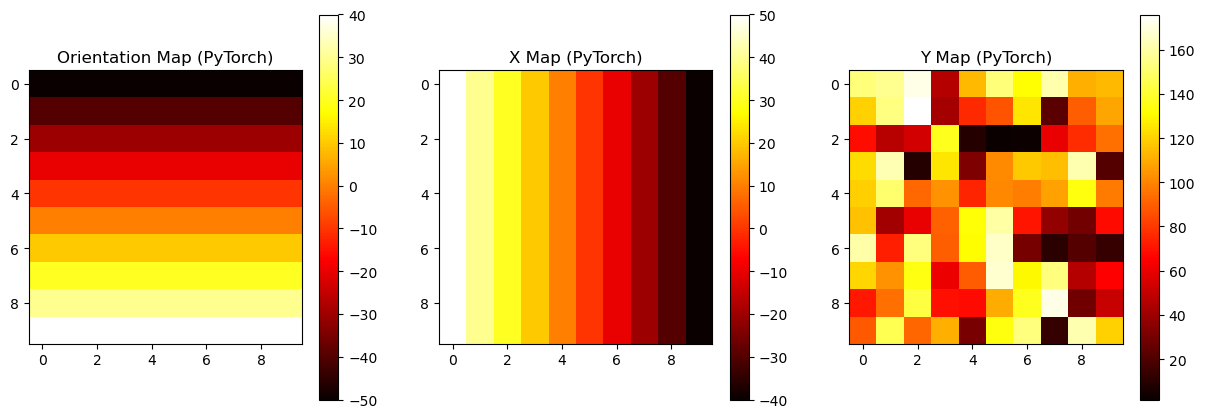

In [22]:
ori_map_pytorch_np = ori_map_pytorch.detach().cpu().numpy()
x_map_pytorch_np = x_map_pytorch.detach().cpu().numpy()
y_map_pytorch_np = y_map_pytorch.detach().cpu().numpy()

# Plotting
plt.figure(figsize=(15, 5))

# Orientation Map
plt.subplot(1, 3, 1)
plt.imshow(ori_map_pytorch_np, cmap='hot')
plt.title('Orientation Map (PyTorch)')
plt.colorbar()

# X Map
plt.subplot(1, 3, 2)
plt.imshow(x_map_pytorch_np, cmap='hot')
plt.title('X Map (PyTorch)')
plt.colorbar()

# Y Map
plt.subplot(1, 3, 3)
plt.imshow(y_map_pytorch_np, cmap='hot')
plt.title('Y Map (PyTorch)')
plt.colorbar()

plt.show()

In [23]:
print(ssn_2d_topo.maps_vec.shape)

torch.Size([200, 3])


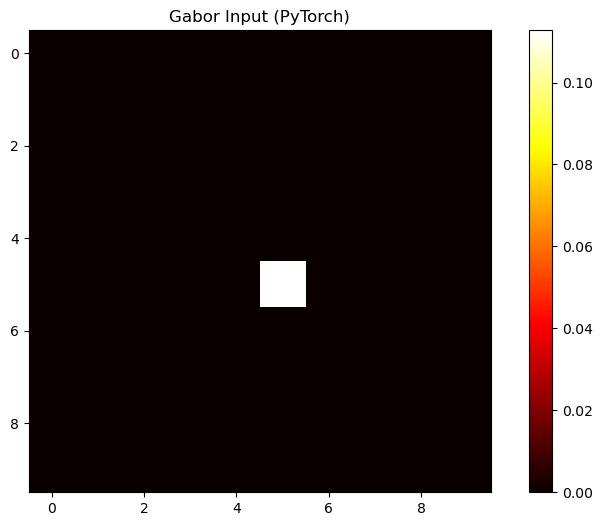

In [24]:
gabor_input_pytorch = ssn_2d_topo.make_gabor_input(sigma_Gabor=0.5, ONLY_E= True,ori_s=ori_s, gE=gE, gI=gI, contrast=contrast)
gabor_input_pytorch_np = gabor_input_pytorch.detach().cpu().numpy()  # Convert to NumPy array for comparison
plt.imshow(gabor_input_pytorch_np.reshape((grid_size, grid_size)), cmap='hot')
plt.title('Gabor Input (PyTorch)')
plt.colorbar()

plt.show()